In [7]:
%pip install torch torchvision torchaudio torch-geometric

  Using cached torch-2.8.0-cp39-cp39-win_amd64.whl (241.2 MB)
  Using cached torchvision-0.23.0-cp39-cp39-win_amd64.whl (1.6 MB)
  Using cached torchaudio-2.8.0-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
     ------------------------------------ 134.9/134.9 KB 498.6 kB/s eta 0:00:00
     ------------------------------------ 201.0/201.0 KB 529.8 kB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 334.9 kB/s eta 0:00:00
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
     ------------------------------------ 457.7/457.7 KB 415.1 kB/s eta 0:00:00
     -------------------------------------- 78.4/78.4 KB 545.1 kB/s eta 0:00:00
  Using cached requests-2.32.5-py3-none-any.whl (64 kB)
     ------------------------------------ 536.2/536.2 KB 118.9 kB/s eta 0:00:00
     -------------------------------------- 46.2/46.2 KB 382.3 kB/s eta 0:00:00
  Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
  Using cached a

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\aravg\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
import numpy as np
from sklearn.model_selection import train_test_split

DATA_PATH_FEATURES = '../data/elliptic_txs_features.csv'
DATA_PATH_CLASSES = '../data/elliptic_txs_classes.csv'
DATA_PATH_EDGES = '../data/elliptic_txs_edgelist.csv'

print("Loading Data... (This will take 1-2 minutes)")
df_classes = pd.read_csv(DATA_PATH_CLASSES)
df_features = pd.read_csv(DATA_PATH_FEATURES, header=None)

# 1. Setup Nodes and Features
df_features.rename(columns={0: 'txId', 1: 'time_step'}, inplace=True)
df_merged = pd.merge(df_features, df_classes, on='txId', how='left')
nodes = df_merged['txId'].values
map_id = {j: i for i, j in enumerate(nodes)}

# 2. Setup Edges
print("Loading Edges and mapping IDs...")
df_edges = pd.read_csv(DATA_PATH_EDGES)
df_edges = df_edges[df_edges['txId1'].isin(nodes) & df_edges['txId2'].isin(nodes)]
src = df_edges['txId1'].map(map_id).values
dst = df_edges['txId2'].map(map_id).values
edge_index = torch.tensor([src, dst], dtype=torch.long)

# 3. Setup Tensors
node_features = df_merged.drop(columns=['txId', 'class', 'time_step']).values
x = torch.tensor(node_features, dtype=torch.float)

df_merged['class'] = df_merged['class'].map({'1': 1, '2': 0, 'unknown': -1})
y = torch.tensor(df_merged['class'].values, dtype=torch.long)

# 4. CREATE DATA OBJECT (MOVED UP)
# We create 'data' HERE so we can use it for splitting below
data = Data(x=x, edge_index=edge_index, y=y)

# 5. Create Train/Test Split
print("Switching to Random Split...")
num_nodes = data.num_nodes  # Now this works because 'data' exists!
all_indices = np.arange(num_nodes)
labeled_indices = all_indices[y != -1] # Only train on labeled nodes

train_idx, test_idx = train_test_split(labeled_indices, test_size=0.3, random_state=42)

# Create Masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask[test_idx] = True

print("Graph Constructed Successfully!")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Training Nodes: {data.train_mask.sum().item()}")
print(f"Test Nodes: {data.test_mask.sum().item()}")

Loading Data... (This will take 1-2 minutes)
Loading Edges and mapping IDs...
Switching to Random Split...
Graph Constructed Successfully!
Number of Nodes: 203769
Number of Edges: 234355
Training Nodes: 32594
Test Nodes: 13970


In [3]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report
class FraudGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(data.num_node_features, 128)
        self.conv2 = SAGEConv(128, 2)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")
model = FraudGNN().to(device)
data = data.to(device)
num_licit = (data.y[data.train_mask] == 0).sum().item()
num_fraud = (data.y[data.train_mask] == 1).sum().item()
weight = torch.tensor([1.0, num_licit / num_fraud], dtype=torch.float).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss(weight=weight)
print("Starting Graph Training...")
for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss.item():.4f}')
print("\n--- GraphSAGE Evaluation ---")
model.eval()
pred = model(data).argmax(dim=1)
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

print(classification_report(y_true, y_pred, target_names=['Licit (0)', 'Fraud (1)']))

Training on: cpu
Starting Graph Training...
Epoch 000, Loss: 0.8138
Epoch 010, Loss: 0.2895
Epoch 020, Loss: 0.2183
Epoch 030, Loss: 0.1790
Epoch 040, Loss: 0.1510
Epoch 050, Loss: 0.1359
Epoch 060, Loss: 0.1242
Epoch 070, Loss: 0.1085
Epoch 080, Loss: 0.1055
Epoch 090, Loss: 0.0990
Epoch 100, Loss: 0.0950

--- GraphSAGE Evaluation ---
              precision    recall  f1-score   support

   Licit (0)       0.99      0.97      0.98     12587
   Fraud (1)       0.74      0.91      0.82      1383

    accuracy                           0.96     13970
   macro avg       0.87      0.94      0.90     13970
weighted avg       0.97      0.96      0.96     13970



In [1]:
%pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
  Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\aravg\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


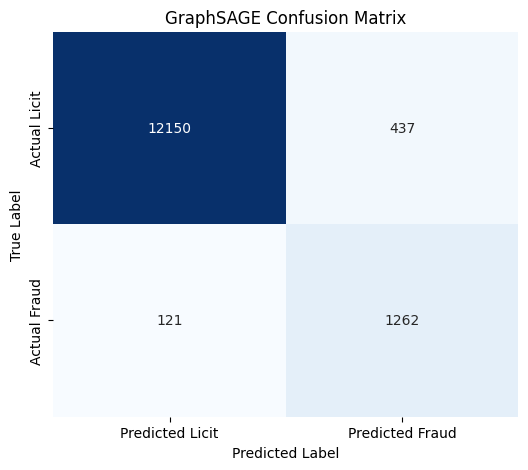

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Get Fresh Predictions (Regenerate y_true and y_pred)
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim=1)
    
    # Move to CPU for plotting
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

# 2. Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plot the Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Licit', 'Predicted Fraud'],
            yticklabels=['Actual Licit', 'Actual Fraud'])
plt.title('GraphSAGE Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [5]:
import torch
import os

# Define the file name
model_filename = "gnn_model_sage.pth"

# Save the model's weights (the learned patterns)
torch.save(model.state_dict(), model_filename)

print(f"✅ Success! Model saved as '{model_filename}'")
print(f"File location: {os.path.abspath(model_filename)}")

✅ Success! Model saved as 'gnn_model_sage.pth'
File location: c:\Users\aravg\crypto-fraud-detection\notebooks\gnn_model_sage.pth
